In [32]:
import os
import numpy as np
import pandas as pd
import mne
import scipy.io
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from mne.decoding import CSP
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [33]:
filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230721'
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']
# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []
o_data65_label1 = list()#label1のデータ
o_data = list()
label_data = list()#labelを結合したデータ
all_data = list()  # 全データを結合
file_name = list()  # すべての.matファイルの名前

In [34]:
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)
#解析するデータを選択
#file_name1 = [file_name[2],file_name[9],file_name[3],file_name[4]]
file_name1 = [file_name[6],file_name[7],file_name[8],file_name[9]]
file_num1 = len(file_name1)
trial_num = 30
all_trial = len(file_name1) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:66, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
print("image data_loading")
print(file_name1)

Filelist
['EEG_grasping_21-Jul-2023_sub1-1.mat', 'EEG_grasping_21-Jul-2023_sub1-2.mat', 'EEG_grasping_21-Jul-2023_sub2-1.mat', 'EEG_grasping_21-Jul-2023_sub2-2.mat', 'EEG_grasping_21-Jul-2023_sub2-3.mat', 'EEG_grasping_21-Jul-2023_sub2-4.mat', 'EEG_grasping_21-Jul-2023_sub3-1.mat', 'EEG_grasping_21-Jul-2023_sub3-2.mat', 'EEG_grasping_21-Jul-2023_sub3-3.mat', 'EEG_grasping_21-Jul-2023_sub3-4.mat']
image data_loading
['EEG_grasping_21-Jul-2023_sub3-1.mat', 'EEG_grasping_21-Jul-2023_sub3-2.mat', 'EEG_grasping_21-Jul-2023_sub3-3.mat', 'EEG_grasping_21-Jul-2023_sub3-4.mat']


In [35]:
#eeg_data
c1 = o_data65_label1[0].eeg[0:64 , 0:10240]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[0:64 , 0:10240]
    c1 = np.dstack([c1, g1])
all_data = c1.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)
#label
label_data = list()#labelを結合したデータ
for n in range(all_trial):
    label_data.append(o_data65_label1[n].label)
label_data = np.array(label_data)
print(np.shape(label_data))

(120, 64, 10240)
(120,)


In [36]:
n_channels = 64
sampling_freq = 1024  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('standard_1020')

events = np.column_stack(
    (
        np.arange(0, 1024*120, sampling_freq),
        np.zeros(120, dtype=int),
        label_data
    )
)
event_dict = dict(condition_A=1, condition_B=2)
simulated_epochs = mne.EpochsArray(
    all_data, info, tmin=-6, events=events, event_id=event_dict)

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


In [37]:
resample_freq = 100
resample_epochs = simulated_epochs.resample(sfreq=resample_freq)
data_flit = resample_epochs.filter(l_freq=2.0,h_freq=30)
ica = mne.preprocessing.ICA(n_components=20,random_state=42,max_iter=800)
ica.fit(data_flit)
ica.plot_components()

In [41]:
from mne_icalabel import label_components
label_components(data_flit, ica, method='iclabel')

/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_61566/2271117657.py:2: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  label_components(data_flit, ica, method='iclabel')
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_61566/2271117657.py:2: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  label_components(data_flit, ica, method='iclabel')
/var/folders/ns/k3cfj44n0x5fzgb4dy4t3l0c0000gn/T/ipykernel_61566/2271117657.py:2: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infoma

{'y_pred_proba': array([0.50381404, 0.8821471 , 0.8582048 , 0.9997231 , 0.99818325,
        0.9943164 , 0.99570876, 0.5616971 , 0.99637157, 0.99157655,
        0.5619958 , 0.99380016, 0.9915934 , 0.71864635, 0.919145  ,
        0.9952401 , 0.8633323 , 0.8055977 , 0.34547353, 0.4077414 ],
       dtype=float32),
 'labels': ['other',
  'brain',
  'eye blink',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'other',
  'brain',
  'brain',
  'other',
  'brain',
  'brain',
  'other',
  'brain',
  'muscle artifact',
  'channel noise']}

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


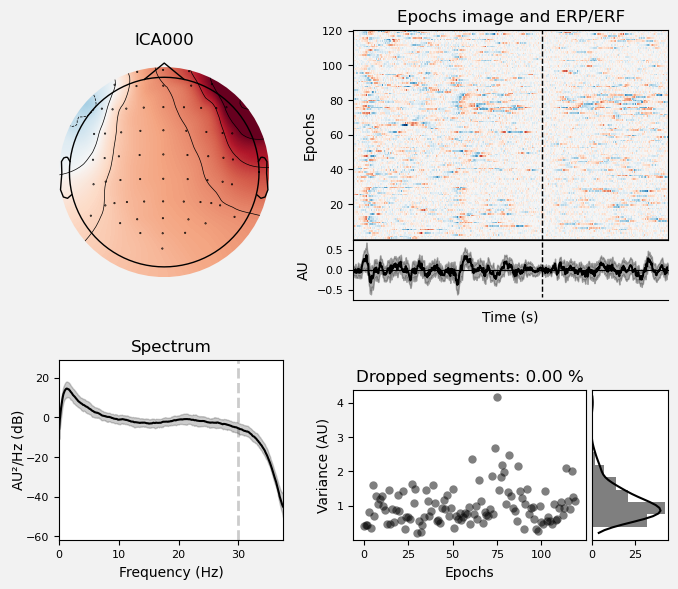

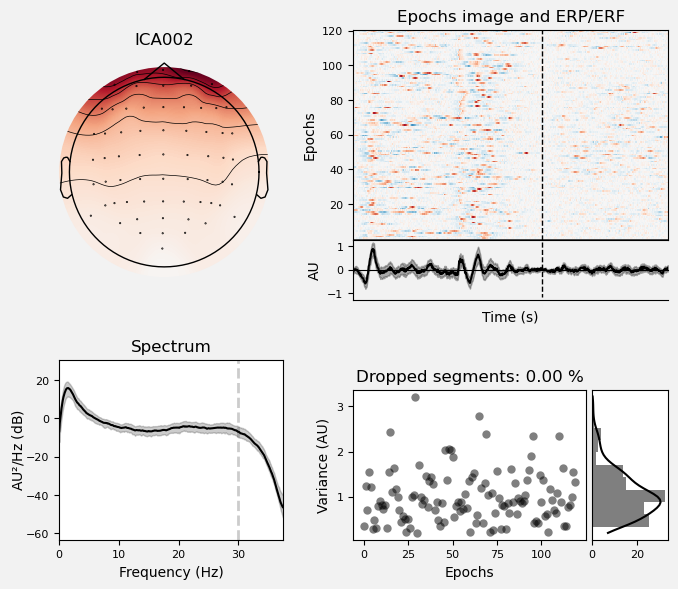

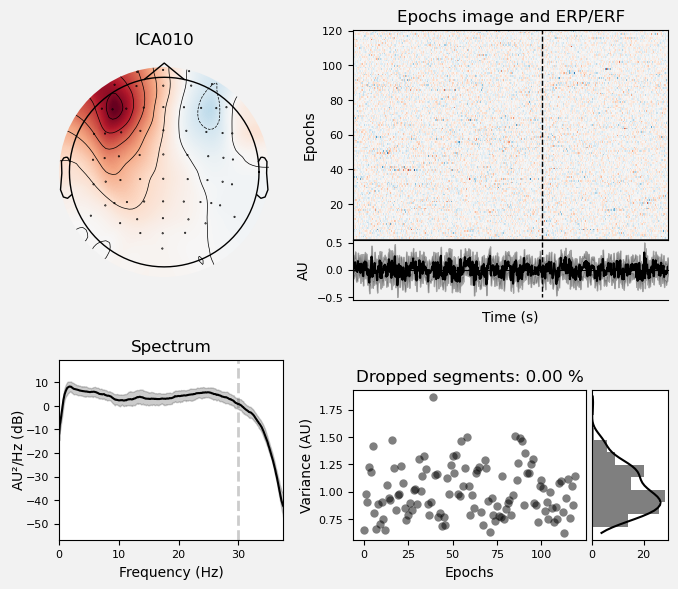

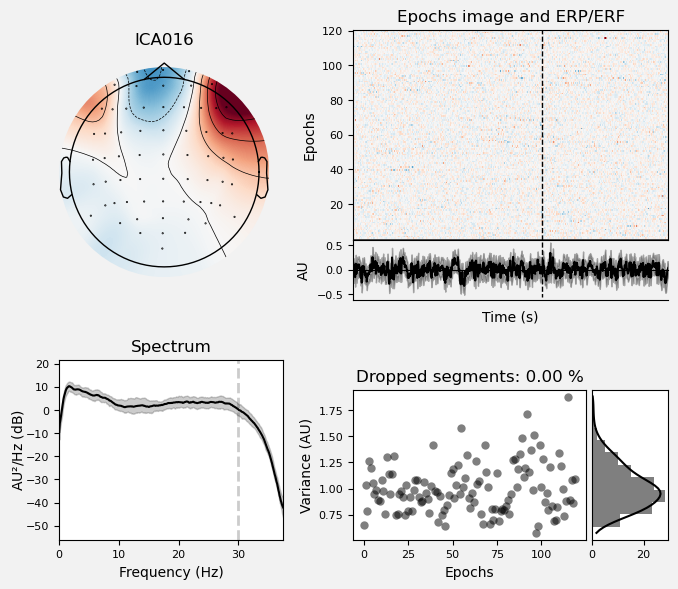

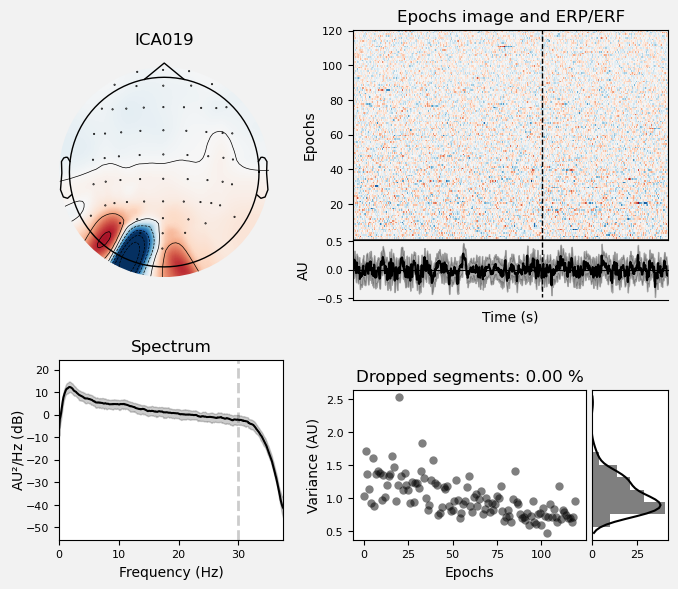

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [42]:
#only brain
#ica.exclude = [0,1,3,4,5,11,13,15,17,19]
#image_only choice
#ica.exclude = [0,1,5]
#7/17
#ica.exclude = [0,2,3,4,5,7,12,13,14,16,17,18,19]
#7/20
#ica.exclude = [0,4,8,19]
#7/21
ica.exclude = [0,2,10,16,19]
ica.plot_properties(data_flit,picks=ica.exclude)

In [43]:
#選択したICAの除去
data_ica = data_flit.copy()
ica.apply(data_ica)
data_ica.apply_baseline(baseline=(-6,-3))


Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 64 PCA components
Applying baseline correction (mode: mean)


Number of events,120
Events,condition_A: 60condition_B: 60
Time range,-6.000 – 3.990 sec
Baseline,-6.000 – -3.000 sec


In [44]:
# #ラプラシアンフィルタの適用
# data_ica_csd = mne.preprocessing.compute_current_source_density(data_ica)

In [54]:
motorbrainAdress = ['FC3','FC1','C1','C3','C5','CP3','CP1','CPz','FC4','FC2',
'FCz','Cz','C2','C4','C6','CP4','CP2',]
# info_motor = mne.create_info(ch_names=motorbrainAdress, ch_types="eeg", sfreq=1024)
# info_motor.set_montage('standard_1020')

・Source Imaging(demo)

In [55]:
#データをnumpyに変換
data_numpy = data_ica.get_data()
print(np.shape(data_numpy))

motor_brainAdress = [9,10,11,12,13,17,18,31,44,45,46,47,48,49,50,54,55]
data_numpy_task  = data_numpy[:,motor_brainAdress,100*6:100*10]

(120, 64, 1000)


In [56]:
#Time frequency
# frq, t, Pxx = scipy.signal.stft(data_numpy_task[1][0], fs=128) #周波数、時間、強さの3つの情報が帰ってくる
# Pxx = 10 * np.log(np.abs(Pxx)) #対数表示に直す


# plt.pcolormesh(t, frq, Pxx, cmap = 'jet')
# plt.show()
# plt.close()

In [57]:
# time_freq_data = list()#時間周波数のデータ
# for n in range(120):  # all_trial
#     for j in range(17):  # motor_channel
#         bmp = list()#1trialの保存先リスト
#         frq, t, Pxx = scipy.signal.stft(data_numpy_task[n][j], fs=100) #周波数、時間、強さの3つの情報が帰ってくる
#         Pxx = 10 * np.log(np.abs(Pxx)) #対数表示に直す
#         bmp.extend(Pxx[:, 1:4])
#     time_freq_data.append(bmp)
  
    

In [58]:
F = np.fft.fft(data_numpy_task[0][0])
freq = np.fft.fftfreq(100*4, d=100)

In [59]:
np.shape(freq)

(400,)

In [60]:
fft_data = list()#時間周波数のデータ
for n in range(120):  # all_trial
    bmp = list()#1trialの保存先リスト
    for j in range(17):  # motor_channel
        fft_res = np.fft.fft(data_numpy_task[n][j])
        Amp = np.abs(fft_res)
        #freq = np.fft.fftfreq(128*4, d=128)
        bmp.append(Amp)
    fft_data.append(bmp)
  

In [61]:
#np.shape(time_freq_data)
np.shape(fft_data)

(120, 17, 400)

In [63]:
#data Reshape
reshape_data = np.reshape(fft_data,(120,17*400))
#train testの分割
X_train, X_test, Y_train, Y_test = train_test_split(reshape_data,label_data, test_size=0.25,random_state=42)
print(np.shape(X_train))

(90, 6800)


In [64]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
# 多層パーセプトロン
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train, Y_train)
mlp_clf.score(X_test, Y_test)

0.5

In [65]:
random_search = {'batch_size': [10, 20, 30, 130],
               'hidden_layer_sizes': [(150, 150), (100, 100, 50), (150, 100, 50)],
               'max_iter': [400, 500, 600, 700, 800],
               'random_state': [42]}
mlp_random_search2 = RandomizedSearchCV(mlp_clf, random_search, cv=3,
                                   n_jobs=-1, scoring='accuracy', random_state=0)
# スケーリングしたデータで実行します
mlp_random_search2.fit(X_train, Y_train)

/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: Use

RandomizedSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
                   param_distributions={'batch_size': [10, 20, 30, 130],
                                        'hidden_layer_sizes': [(150, 150),
                                                               (100, 100, 50),
                                                               (150, 100, 50)],
                                        'max_iter': [400, 500, 600, 700, 800],
                                        'random_state': [42]},
                   random_state=0, scoring='accuracy')

In [66]:
# 実行
cvres = mlp_random_search2.cv_results_
for score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(score, params)

0.5666666666666665 {'random_state': 42, 'max_iter': 500, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 20}
0.4666666666666666 {'random_state': 42, 'max_iter': 400, 'hidden_layer_sizes': (100, 100, 50), 'batch_size': 30}
0.5555555555555555 {'random_state': 42, 'max_iter': 800, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 130}
0.5666666666666665 {'random_state': 42, 'max_iter': 700, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 20}
0.5222222222222223 {'random_state': 42, 'max_iter': 500, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 10}
0.5222222222222221 {'random_state': 42, 'max_iter': 600, 'hidden_layer_sizes': (150, 150), 'batch_size': 10}
0.5666666666666667 {'random_state': 42, 'max_iter': 800, 'hidden_layer_sizes': (150, 150), 'batch_size': 30}
0.5555555555555555 {'random_state': 42, 'max_iter': 700, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 130}
0.5222222222222223 {'random_state': 42, 'max_iter': 400, 'hidden_layer_sizes': (150, 100, 50), 'batch_

In [67]:
mlp_random_search2.score(X_test, Y_test)

0.5666666666666667

In [68]:
#時系列データのSVM
model =SVC(kernel='linear')
model.fit(X_train,Y_train)
print(model.score(X_test, Y_test))

0.4666666666666667


In [69]:
params = {
    "C":np.logspace(-2,10,13),
    "kernel":["rbf","linear","sigmoid","poly"],
    "gamma":np.logspace(-9,3,13)
}
grid = GridSearchCV(model, params,scoring="accuracy", cv=5)

grid.fit(X_train,Y_train)

print("grid_best_score=",grid.best_score_)
print(grid.best_params_)

pred = grid.predict(X_test)
print(classification_report(Y_test, pred))

grid_best_score= 0.5444444444444445
{'C': 100000000.0, 'gamma': 1e-07, 'kernel': 'sigmoid'}
              precision    recall  f1-score   support

           1       0.44      0.53      0.48        15
           2       0.42      0.33      0.37        15

    accuracy                           0.43        30
   macro avg       0.43      0.43      0.43        30
weighted avg       0.43      0.43      0.43        30

